In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ranksums

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path

from ftplib import FTP

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-dark-palette')
%matplotlib inline

Below is code to automatically grab a file from the FTP for RNAcentral. FTPlib doesn't like large files though, so I ended up doing it manually. 

In [6]:
# HOSTNAME = 'ftp.ebi.ac.uk'

# ftp = FTP(HOSTNAME)

# ftp.login()

# ftp.cwd('pub/databases/RNAcentral/current_release/json')

# filename = 'ensembl-xref-1-100001.json'

# with open(filename, "w") as rna_json:
#     ftp.retrlines(f"RETR {filename}", rna_json.write)


Instead of automated requests, I grabbed a few of the JSON files from the FTP, which can be read in with the following function. 

In [2]:
def load_rna(fname, inc_other=True, merge_other=True, simple_descrips=False, drop=True):
    rna = pd.read_json(fname)
    
    # drop extra columns which reference external databases -- always
    rna = rna.drop(['xrefs', 'md5'], axis=1)
    
    # make the column names pretty
    cols = {'rnacentral_id': 'RNA ID', 'description': 'Description', 'sequence':'Sequence', 'rna_type': 'RNA Type', 'taxon_id': 'Taxon ID'}
    rna = rna.rename(columns=cols)
    
    # remove underscores from RNA type
    rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('_', ' ')), axis=1)
    
    # combine the 'other', 'misc', 'nc', and 'lnc' types\n",
    if merge_other:
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('misc RNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('lncRNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('ncRNA', 'other')), axis=1)

    # drop rows with unclassified RNAs? 
    if not inc_other:
        rna = rna[rna['RNA Type'] != 'other']
        
        if not merge_other:
            rna = rna[rna['RNA Type'] != 'misc RNA']
            rna = rna[rna['RNA Type'] != 'ncRNA']
            rna = rna[rna['RNA Type'] != 'lncRNA']
    
    # Remove everything except latin name from species description
    if simple_descrips:
        rna['Description'] = rna.apply(lambda row : (row['Description'].split(' ')[0] + ' ' + row['Description'].split(' ')[1]), axis=1)\
        
    # drop extra columns with unnecessary info -- optional
    if drop:
        rna = rna.drop(['Taxon ID', 'RNA ID', 'Description'], axis=1)
    
    return rna



In [3]:
# load a batch of data files from RNAcentral or load in a single file?
load_all = True

if load_all:
    p = Path()
    p = p / 'data'
    files = p.glob('ensembl-*')
    rna = pd.DataFrame()

    for file in files:
        try: 
            print(f'Loading data from {str(file)}')
            rna = pd.concat([rna, load_rna(str(file), inc_other=False)])
        except:
            print(f'Could not load data from {str(file)}')

    print('All data loaded.')

else:
    rna = load_rna('data\ensembl-xref-34100001-34200001.json')


Loading data from data\ensembl-xref-10000001-10100001.json
Loading data from data\ensembl-xref-16500001-16600001.json
Loading data from data\ensembl-xref-22600001-22700001.json
Loading data from data\ensembl-xref-29100001-29200001.json
Loading data from data\ensembl-xref-29200001-29300001.json
Loading data from data\ensembl-xref-34100001-34200001.json
Loading data from data\ensembl-xref-6800001-6900001.json
Loading data from data\ensembl-xref-6900001-7000001.json
Loading data from data\ensembl-xref-7000001-7100001.json
Loading data from data\ensembl-xref-7100001-7200001.json
Loading data from data\ensembl-xref-7200001-7300001.json
Loading data from data\ensembl-xref-7300001-7400001.json
Loading data from data\ensembl-xref-7400001-7500001.json
Loading data from data\ensembl-xref-9400001-9500001.json
All data loaded.


In [4]:
def contract_families(types):
    
    classification = []
    
    classes = {'cis-reg': ['IRES', 'leader', 'riboswitch'], 
               'intron': ['autocatalytically spliced intron', 'intron gpI', 'intron gpII', 'intron'],
                  'gene': ['tRNA', 'rRNA', 'snRNA', 'snoRNA', 'pre miRNA', 'hammerhead ribozyme', 'SRP RNA', 'sRNA', 'Y RNA',
                          'RNase P RNA', 'lncRNA', 'tmRNA', 'RNase MRP RNA', 'vault RNA', 'ribozyme', 'miRNA', 'antisense RNA',
                          'telomerase RNA', 'scRNA', 'precursor RNA', 'scaRNA', 'piRNA'], 'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for c  in classes.keys():
            if t in classes[c]:
                classification.append(c)
                flag = True
                break

        if not flag:
            classification.append(t)


    family = []
    
    families = {'tRNA': ['tRNA', 'tmRNA'], 'rRNA': ['rRNA', 'SRP RNA', 'Y RNA'], 'snRNA': 'snRNA', 
                'snoRNA': ['snoRNA', 'scRNA', 'scaRNA'], 'miRNA': ['pre miRNA', 'miRNA', 'piRNA'], 'precursor RNA': ['precursor RNA'],
                'ribozyme': ['hammerhead ribozyme', 'RNase P RNA', 'RNase MRP RNA', 'ribozyme', 'autocatalytically spliced intron'], 
                'sRNA': ['sRNA'], 'antisense': ['antisense'], 'vault RNA': ['vault RNA'], 'telomerase RNA': ['telomerase RNA'],
                'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for f in families.keys():
            if t in families[f]:
                family.append(f)
                flag = True
                break

        if not flag:
            family.append(t)
            
    return classification, family

In [5]:
rna['RNA Class'], rna['RNA Family'] = contract_families(rna['RNA Type'])
rna.head()

,Sequence,RNA Type,RNA Class,RNA Family
0,GGAGGGTAAGCTCAGTGGTTAGAATACATGCTTAGCATGCAGGAGG...,tRNA,gene,tRNA
3,ATGCTAGCTTCAGCAGCACATATGCTAAAATTGGAATGATACAGAG...,snRNA,gene,snRNA
4,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA,gene,sRNA
5,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA,gene,sRNA
6,GCCGGGTGTGGCGGCGTGCACCTGTAGTCCCAGTTACTTGGAGGCT...,SRP RNA,gene,rRNA


In [6]:
merge_sequence = rna.groupby("Sequence").agg({'RNA Type':'first'}).reset_index()
merge_sequence['RNA Class'], merge_sequence['RNA Family'] = contract_families(merge_sequence['RNA Type'])
print(len(rna))
print(len(merge_sequence))
merge_sequence.head()

734593
595938


,Sequence,RNA Type,RNA Class,RNA Family
0,AAAAAAAAAAAAAAAAAAAAAAAATCCCTTTTTTTTTTTTTTTTTT...,ribozyme,gene,ribozyme
1,AAAAAAAAAAAAAAAAAAAAAGAAATGCCCGATCTCATCTGAATTC...,rRNA,gene,rRNA
2,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA
3,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA
4,AAAAAAAAAAAAAAAGGACCATACTGGGATCAGCCAGCCAGTGGGT...,snRNA,gene,snRNA


In [7]:
def visual_comp_merged(original_seq, merged_seq, cat='RNA Type'):
    typcount = original_seq[cat].value_counts()
    mtypcount = merged_seq[cat].value_counts()
    xpos = np.arange(0, 2*len(typcount.index), 2)
    
    plt.figure()
    plt.bar(x=xpos, height=typcount, log=True, width=-0.8, align='edge', tick_label=typcount.index, label='Original')
    plt.bar(x=xpos, height=mtypcount, log=True, width=0.8, align='edge', label='Merged')

    plt.xticks(rotation=90)
    plt.xlabel(f'{cat}')
    plt.ylabel('Log count')
    plt.legend();

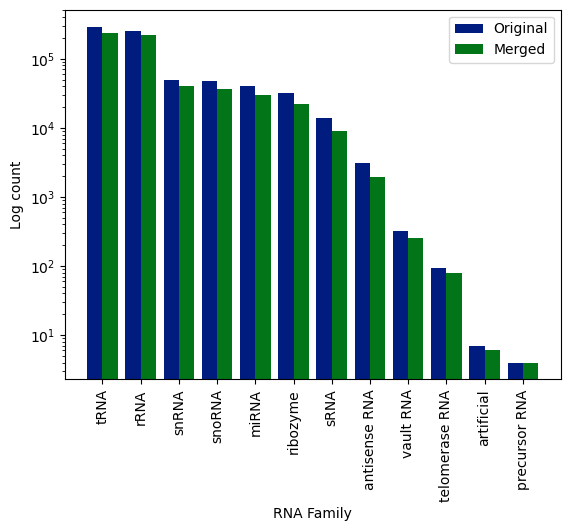

In [8]:
merge_sequence['RNA Class'], merge_sequence['RNA Family'] = contract_families(merge_sequence['RNA Type'])
# visual_comp_merged(rna, merge_sequence)
# visual_comp_merged(rna, merge_sequence, 'RNA Class')
visual_comp_merged(rna, merge_sequence, 'RNA Family')

Feature engineering below includes: sequence length, nucleic acid ratios (ratios of A:T:C:G), ...

In [9]:
merge_sequence['Sequence len'] = merge_sequence['Sequence'].str.len()

seq = merge_sequence.loc[:, 'Sequence']

def nucleic_acid_ratios(target):
    A = 0
    C = 0
    T = 0
    G = 0
    N = 0
    bad_vals = 0;
    for ch in target:
        if (ch == "A"):
            A += 1
        elif (ch == 'C'):
            C += 1;
        elif (ch == 'T'):
            T += 1;
        elif (ch == 'G'):
            G += 1;
        elif (ch == 'N'):
            N += 1;
        else:
            bad_vals += 1

    seq_len = len(target)
    a_rat = A / seq_len
    c_rat = C / seq_len
    t_rat = T / seq_len
    g_rat = G / seq_len
    n_rat = N / seq_len
    
    return a_rat, c_rat, t_rat, g_rat, n_rat;



In [10]:
merge_sequence["A Ratio"] = 0
merge_sequence["C Ratio"] = 0
merge_sequence["T Ratio"] = 0
merge_sequence["G Ratio"] = 0
merge_sequence["N Ratio"] = 0


for i in range (len(seq)):
    a_rat, c_rat, t_rat, g_rat, n_rat = nucleic_acid_ratios(seq[i])
    merge_sequence.loc[i, "A Ratio"] = a_rat
    merge_sequence.loc[i, "C Ratio"] = c_rat
    merge_sequence.loc[i, "T Ratio"] = t_rat
    merge_sequence.loc[i, "G Ratio"] = g_rat
    merge_sequence.loc[i, "N Ratio"] = n_rat

merge_sequence.head()

,Sequence,RNA Type,RNA Class,RNA Family,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio
0,AAAAAAAAAAAAAAAAAAAAAAAATCCCTTTTTTTTTTTTTTTTTT...,ribozyme,gene,ribozyme,168,0.363095,0.136905,0.404762,0.095238,0.0
1,AAAAAAAAAAAAAAAAAAAAAGAAATGCCCGATCTCATCTGAATTC...,rRNA,gene,rRNA,119,0.369748,0.159664,0.201681,0.268908,0.0
2,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.220859,0.269939,0.0
3,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.226994,0.263804,0.0
4,AAAAAAAAAAAAAAAGGACCATACTGGGATCAGCCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.257669,0.239264,0.226994,0.276074,0.0


In [12]:
x = merge_sequence.loc[:, ['Sequence len', 'A Ratio', 'C Ratio', 'T Ratio', 'G Ratio', 'N Ratio']]
y = merge_sequence.loc[:, 'RNA Family']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

x_train.head()

,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio
452344,71,0.211268,0.197183,0.338028,0.253521,0.0
181690,124,0.314516,0.193548,0.338710,0.153226,0.0
131061,993,0.239678,0.214502,0.266868,0.277946,0.0
219761,82,0.195122,0.219512,0.292683,0.292683,0.0
255978,73,0.205479,0.246575,0.219178,0.328767,0.0


In [13]:
ridge = RidgeClassifier().fit(x_train, y_train)
ridge.score(x_train, y_train)

0.7083084968367904

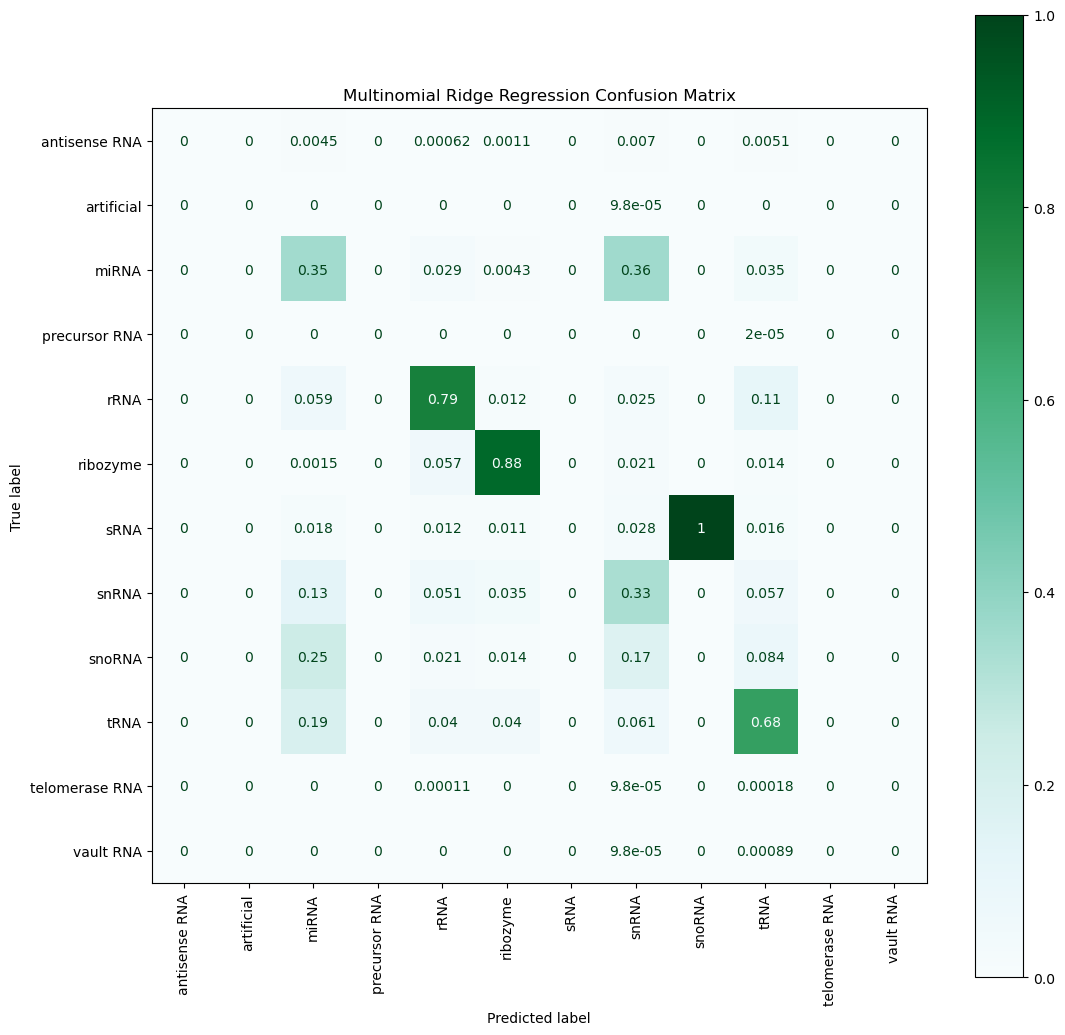

In [14]:
y_pred = ridge.predict(x_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Multinomial Ridge Regression Confusion Matrix')
plt.show()

In [15]:
rfc = RandomForestClassifier().fit(x_train, y_train)
rfc.score(x_train, y_train)

0.9864705793958094

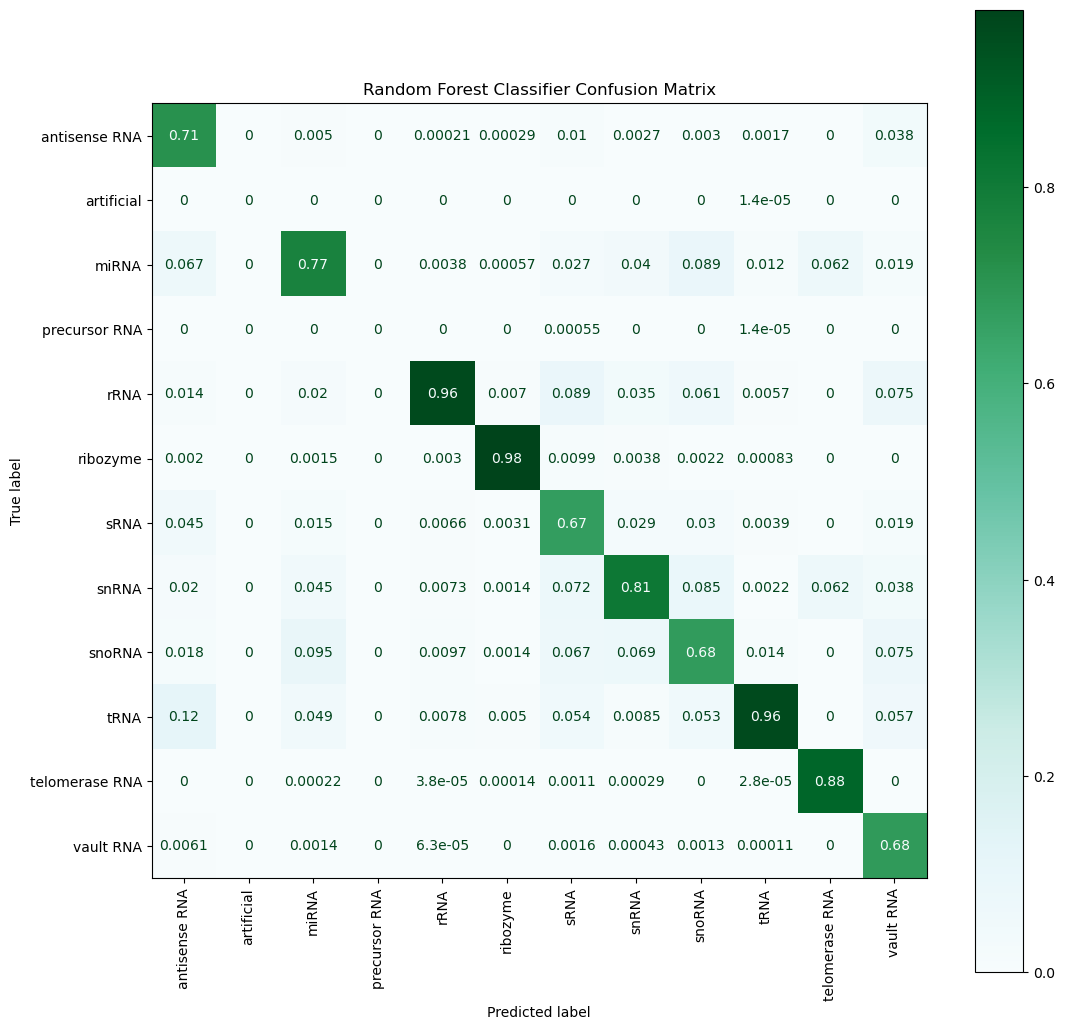

In [16]:
y_pred_rfc = rfc.predict(x_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()

In [17]:
def multiclass_metrics(y_test, y_pred):
    prec = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
    acc = metrics.balanced_accuracy_score(y_test, y_pred)
    
    print(f'Precision score: {prec}')
    print(f'Recall score: {rec}')
    print(f'Balanced accuracy score: {acc}')

In [18]:
print('Ridge classifier metrics:')
multiclass_metrics(y_test, y_pred)
print('\nRandom Forest classifier metrics:')
multiclass_metrics(y_test, y_pred_rfc)

Ridge classifier metrics:
Precision score: 0.6351083330403798
Recall score: 0.7076324621173599
Balanced accuracy score: 0.18216894971325667

Random Forest classifier metrics:
Precision score: 0.918604905154969
Recall score: 0.9207515509000305
Balanced accuracy score: 0.5813518780178257


In [20]:
ridge_score, ridge_permutations, ridge_pval = permutation_test_score(ridge, x_test, y_test, n_permutations=1000, n_jobs=-1, scoring='accuracy')
# rfc_score, rfc_permutations, rfc_pval = permutation_test_score(rfc, x_test, y_test, n_permutations=10, n_jobs=-1, scoring='accuracy')

plt.figure(figsize=[12.5, 12.5])
# plt.subplot(2, 1, 1)

plt.hist(ridge_permutations, label='Ridge', density=True, bins=100, range=(0, 1))

plt.title('Permutation testing of Ridge Regression')
plt.legend()
plt.xlim(0, 1)
plt.xlabel('Accuracy score')
plt.ylabel('Probability')
plt.axvline(ridge_score, color='r', linestyle='dashed')

# plt.subplot(2, 1, 2)

# plt.hist(rfc_permutations, label="Random Forest", bins=20)

# plt.legend()
# plt.xlim(0, 1)
# plt.xlabel('Accuracy score')
# plt.ylabel('Probability')
# plt.axvline(rfc_score, color='r', linestyle='dashed');
# plt.title('Permutation testing of Random Forest Model')

print(f'P-value that the accuracy score of the Ridge Regression by chance: {ridge_pval: 0.4f}')
# print(f'P-value that the accuracy score of the Random Forest is by chance: {rfc_pval: 0.4f}')

KeyboardInterrupt: 

In [21]:
def class_accuracies(cm, ks):
    
    per_class_accuracies = {}
    
    for idx, cls in enumerate(ks):
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))

        true_positives = cm[idx, idx]

        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
        
    return per_class_accuracies

P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.0179
P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.2253


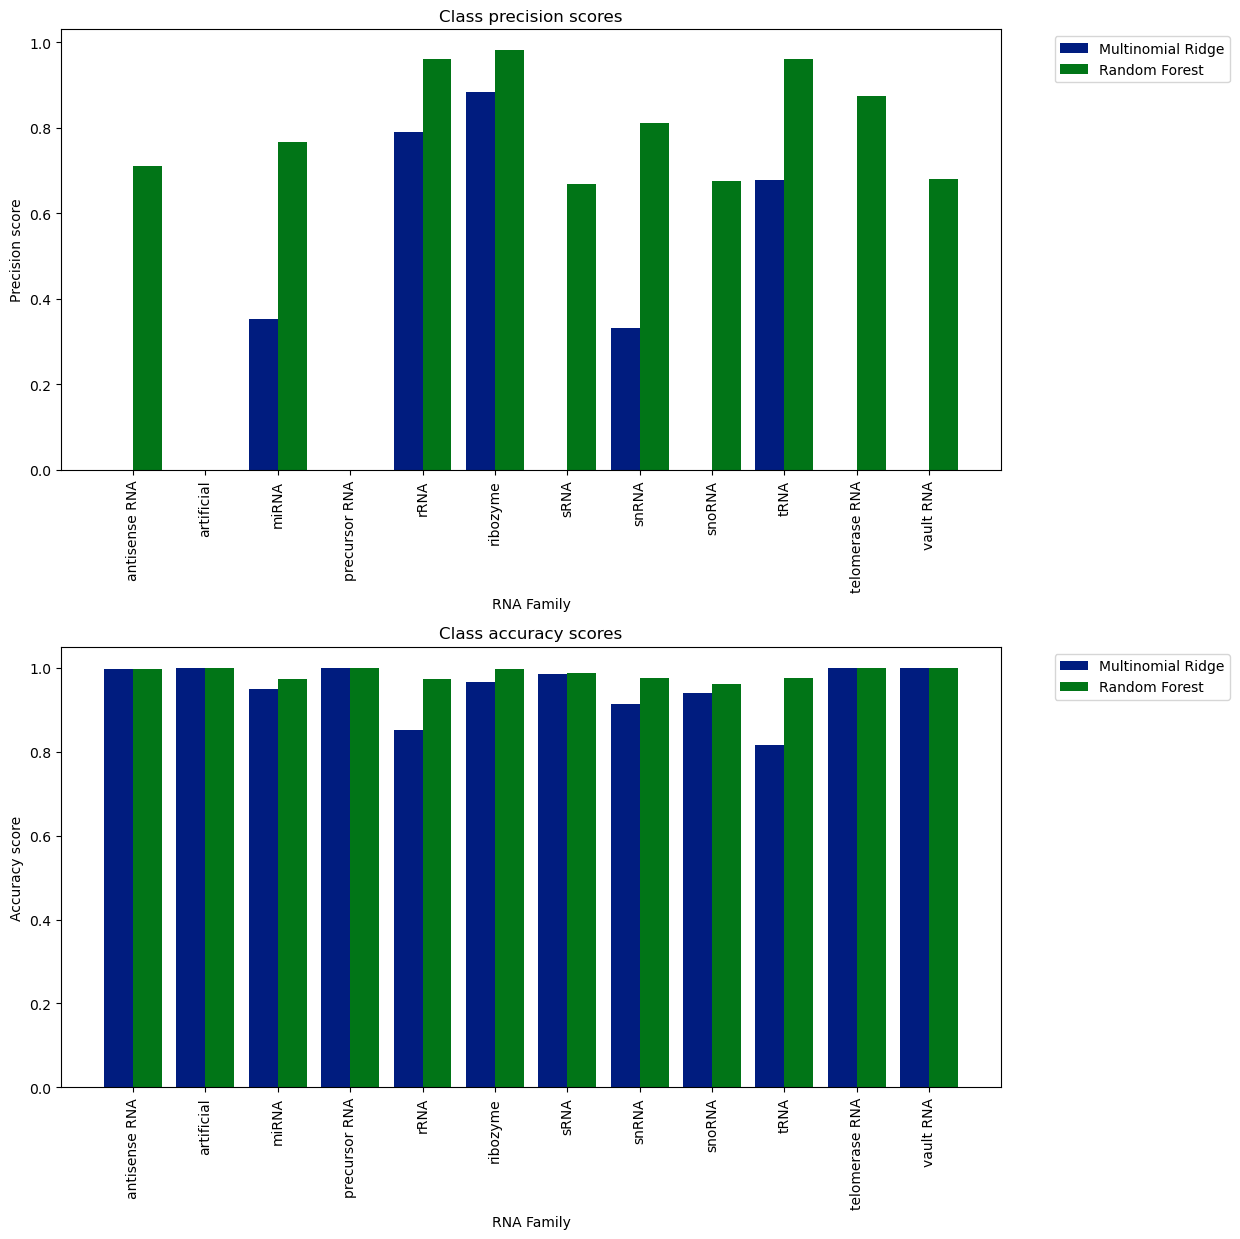

In [22]:
# metrics.multilabel_confusion_matrix(y_test, y_pred)
# metrics.multilabel_confusion_matrix(y_test, y_pred_rfc)
ridge_stats = metrics.classification_report(y_test, y_pred, zero_division=0, output_dict=True)
rfc_stats = metrics.classification_report(y_test, y_pred_rfc, zero_division=0, output_dict=True)


ridge_prec_sep = []
rfc_prec_sep = []

ks = list(rfc_stats.keys())[0:len(ridge.classes_)]

for c in ks:
    ridge_prec_sep.append(ridge_stats[c]['precision'])
    rfc_prec_sep.append(rfc_stats[c]['precision'])
    

xpos = np.arange(0, 2*len(ks), 2)
    
plt.figure(figsize=[12.5, 12.5])
plt.subplot(2, 1, 1)
plt.bar(x=xpos, height=ridge_prec_sep, width=-0.8, align='edge', tick_label=ks, label='Multinomial Ridge')
plt.bar(x=xpos, height=rfc_prec_sep, width=0.8, align='edge', label='Random Forest')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Precision score')
plt.xlabel('RNA Family')
plt.title('Class precision scores')
plt.tight_layout()


plt.subplot(2, 1, 2)

ridge_cm = metrics.confusion_matrix(y_test, y_pred)
rfc_cm = metrics.confusion_matrix(y_test, y_pred_rfc)

ridge_accs = class_accuracies(ridge_cm, ks)
rfc_accs = class_accuracies(rfc_cm, ks)

plt.bar(x=xpos, height=list(ridge_accs.values()), width=-0.8, align='edge', tick_label=ks, label='Multinomial Ridge')
plt.bar(x=xpos, height=list(rfc_accs.values()), width=0.8, align='edge', label='Random Forest')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Accuracy score')
plt.xlabel('RNA Family')
plt.title('Class accuracy scores')
plt.tight_layout();

_, p_prec = ranksums(ridge_prec_sep, rfc_prec_sep)
_, p_accs = ranksums(list(ridge_accs.values()), list(rfc_accs.values()))

print(f'P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_prec: 0.4f}')
print(f'P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_accs: 0.4f}')

In [ ]:
from textwrap import wrap
seq = merge_sequence.loc[:, 'Sequence']
def nucleic_acid_triples(seq):
    n = 3
    seq_split = [seq[k:k+n] for k in range (0, len(seq), n)]
    return (seq_split);

merge_sequence['Codon Triples'] = 0

for i in range (len(seq)):
    merge_sequence.loc[:, "Codon Triples"] = merge_sequence.loc[:,"Codon Triples"].astype('object')
    triples = nucleic_acid_triples(seq[i])
    merge_sequence.at[i, "Codon Triples"] = triples

EIIP are the electron-ion interaction pseudopotentials of each nucelotide. This is the standard scalar representation of RNA sequences (using U val for T)

A = 0.1260, U = 0.1335,G =  0.0806, and C = 0.1340
Output dimensions of EIIP should be equal to the length of the original sequence

In [23]:
def chemical_encoding(target):
    template_seq = ''
    EIIP = []
    for ch in target:
        if (ch == "A"):
            template_seq += "T"
            EIIP.append(0.1260)
        elif (ch == 'C'):
            template_seq += "G"
            EIIP.append(0.1340)
        elif (ch == 'T'):
            template_seq += "A"
            EIIP.append(0.1335)
        elif (ch == 'G'):
            template_seq += "C"
            EIIP.append(0.0806)
        elif (ch == 'N'):
            template_seq += "N"
            EIIP.append(0.0000)
#         else:
#             template_seq += ch       
    return template_seq, EIIP;
merge_sequence['EIIP'] = 0

for i in range (len(seq)):
    pair_seq, EIIP = chemical_encoding(seq[i])
    # merge_sequence.loc[i, "Nucleotide Pairing"] = pair_seq
    merge_sequence["EIIP"] = merge_sequence["EIIP"].astype('object')
    merge_sequence.at[i, "EIIP"] = [EIIP]


KeyboardInterrupt: 

In [24]:
x_extended = merge_sequence.loc[:, ['Sequence len', 'A Ratio', 'C Ratio', 'T Ratio', 'G Ratio', 'N Ratio', 'EIIP']]

x_train_extended, x_test_extended, y_train, y_test = train_test_split(x_extended, y, test_size=0.33)

#x_train.head()
x_extended.head()

,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio,EIIP
0,168,0.363095,0.136905,0.404762,0.095238,0.0,"[[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0...."
1,119,0.369748,0.159664,0.201681,0.268908,0.0,"[[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0...."
2,163,0.282209,0.226994,0.220859,0.269939,0.0,"[[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0...."
3,163,0.282209,0.226994,0.226994,0.263804,0.0,"[[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0...."
4,163,0.257669,0.239264,0.226994,0.276074,0.0,"[[0.126, 0.126, 0.126, 0.126, 0.126, 0.126, 0...."


In [25]:
# merge_sequence.loc[:, ['EIIP']]

for i in range(len(merge_sequence)):
    for j in range(len(merge_sequence['EIIP'][i][0])):
        EIIP_sum = 0
        EIIP_sum += merge_sequence['EIIP'][i][0][j]
    EIIP_avg = EIIP_sum / len(merge_sequence['EIIP'][i][0])
    merge_sequence.at[i, "EIIP Average"] = EIIP_avg

KeyboardInterrupt: 

In [26]:
x2 = merge_sequence.loc[:, ['Sequence len', 'EIIP Average']]
y = merge_sequence.loc[:, 'RNA Family']

x2_train, x2_test, y_train, y_test = train_test_split(x2, y, test_size=0.33)

x2_train.head()

,Sequence len,EIIP Average
325408,73,NaN
129822,638,NaN
289452,72,NaN
590486,2536,NaN
73563,180,NaN


In [27]:
ridge_eiip = RidgeClassifier().fit(x2_train, y_train)
ridge_eiip.score(x2_train, y_train)

y_pred = ridge_eiip.predict(x2_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Multinomial Ridge Regression Confusion Matrix with EIIP averages')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [28]:
rfc_eiip = RandomForestClassifier().fit(x2_train, y_train)
rfc_eiip.score(x2_train, y_train)

y_pred_rfc_eiip = rfc_eiip.predict(x2_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc_eiip, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Random Forest Classifier Confusion Matrix for EIIP values')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
ridge_score_eiip, ridge_permutations_eiip, ridge_pval_eiip = permutation_test_score(ridge_eiip, x2_test, y_test, n_permutations=1000, n_jobs=-1, scoring='accuracy')

plt.figure(figsize=[12.5, 12.5])

plt.hist(ridge_permutations_eiip, label='Ridge', density=True, bins=100, range=(0, 1))

plt.title('Permutation testing of Ridge Regression on EIIP Avergage Values')
plt.legend()
plt.xlim(0, 1)
plt.xlabel('Accuracy score')
plt.ylabel('Probability')
plt.axvline(ridge_score_eiip, color='r', linestyle='dashed')

print(f'P-value that the accuracy score of the Ridge Regression by chance: {ridge_pval_eiip: 0.4f}')

In [ ]:
# metrics.multilabel_confusion_matrix(y_test, y_pred)
# metrics.multilabel_confusion_matrix(y_test, y_pred_rfc)
ridge_stats_eiip = metrics.classification_report(y_test, y_pred, zero_division=0, output_dict=True)
rfc_stats_eiip = metrics.classification_report(y_test, y_pred_rfc_eiip, zero_division=0, output_dict=True)


ridge_prec_sep_eiip = []
rfc_prec_sep_eiip = []

ks = list(rfc_stats_eiip.keys())[0:len(ridge.classes_)]

for c in ks:
    ridge_prec_sep_eiip.append(ridge_stats_eiip[c]['precision'])
    rfc_prec_sep_eiip.append(rfc_stats[c]['precision'])
    

xpos = np.arange(0, 2*len(ks), 2)
    
plt.figure(figsize=[12.5, 12.5])
plt.subplot(2, 1, 1)
plt.bar(x=xpos, height=ridge_prec_sep_eiip, width=-0.8, align='edge', tick_label=ks, label='Multinomial Ridge for EIIP')
plt.bar(x=xpos, height=rfc_prec_sep_eiip, width=0.8, align='edge', label='Random Forest for EIIP')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Precision score')
plt.xlabel('RNA Family')
plt.title('Class precision scores')
plt.tight_layout()


plt.subplot(2, 1, 2)

ridge_cm_eiip = metrics.confusion_matrix(y_test, y_pred)
rfc_cm_eiip = metrics.confusion_matrix(y_test, y_pred_rfc_eiip)

ridge_accs_eiip = class_accuracies(ridge_cm_eiip, ks)
rfc_accs_eiip = class_accuracies(rfc_cm_eiip, ks)

plt.bar(x=xpos, height=list(ridge_accs.values()), width=-0.8, align='edge', tick_label=ks, label='Multinomial Ridge for EIIP')
plt.bar(x=xpos, height=list(rfc_accs.values()), width=0.8, align='edge', label='Random Forest for EIIP')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Accuracy score')
plt.xlabel('RNA Family')
plt.title('Class accuracy scores')
plt.tight_layout();

_, p_prec_eiip = ranksums(ridge_prec_sep_eiip, rfc_prec_sep_eiip)
_, p_accs_eiip = ranksums(list(ridge_accs_eiip.values()), list(rfc_accs_eiip.values()))

print(f'P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_prec_eiip: 0.4f}')
print(f'P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_accs_eiip: 0.4f}')